In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.spatial import distance as dist

plt.rcParams['figure.figsize'] = (10.0, 10.0)

1 - <span style="color:rgb(255,0,0)">Ateromová tkáň</span><br>
2 - <span style="color:rgb(0,255,0)">Fibrózní vazivo</span><br>
3 - <span style="color:rgb(0,0,255)">Kalcifikace</span><br>
4 - <span style="color:rgb(85,0,0)">Krvácení staré</span><br>
5 - <span style="color:rgb(0,170,0)">Krvácení čerstvé</span><br>
6 - <span style="color:rgb(255,0,127)">Trombóza stará</span><br>
7 - <span style="color:rgb(0,255,255)">Trombóza čerstvá</span><br>
8 - <span style="color:rgb(0,85,0)">Novotvorba cév</span><br>
9 - <span style="color:rgb(255,0,255)">Lumen</span><br>
10-<span style="color:rgb(255,85,0)">Zánět</span><br>
11-<span style="color:rgb(255,165,0)">Makrofágy (OBR)</span><br>
12-<span style="color:rgb(255,255,0)">Hemosiderin siderofágy</span><br>
13-<span style="color:rgb(128,130,128)">Unknown</span><br>

In [84]:
1 - <span style="color:rgb(255,0,0)">Ateromová tkáň</span><br>
2 - <span style="color:rgb(0,255,0)">Fibrózní vazivo</span><br>
3 - <span style="color:rgb(0,0,255)">Kalcifikace</span><br>
4 - <span style="color:rgb(85,0,0)">Krvácení staré</span><br>
5 - <span style="color:rgb(0,170,0)">Krvácení čerstvé</span><br>
6 - <span style="color:rgb(255,0,127)">Trombóza stará</span><br>
7 - <span style="color:rgb(0,255,255)">Trombóza čerstvá</span><br>
8 - <span style="color:rgb(0,85,0)">Novotvorba cév</span><br>
9 - <span style="color:rgb(255,0,255)">Lumen</span><br>
10-<span style="color:rgb(255,85,0)">Zánět</span><br>
11-<span style="color:rgb(255,165,0)">Makrofágy (OBR)</span><br>
12-<span style="color:rgb(255,255,0)">Hemosiderin siderofágy</span><br>

13-<span style="color:rgb(128,130,128)">Unknown</span><br>

SyntaxError: invalid syntax (<ipython-input-84-b6e78ce5e664>, line 1)

In [65]:
img = cv.imread('../data/doctor_annotations/y_raw_contours/3315_15_2062.png')
# img = img.astype(dtype=np.uint8)

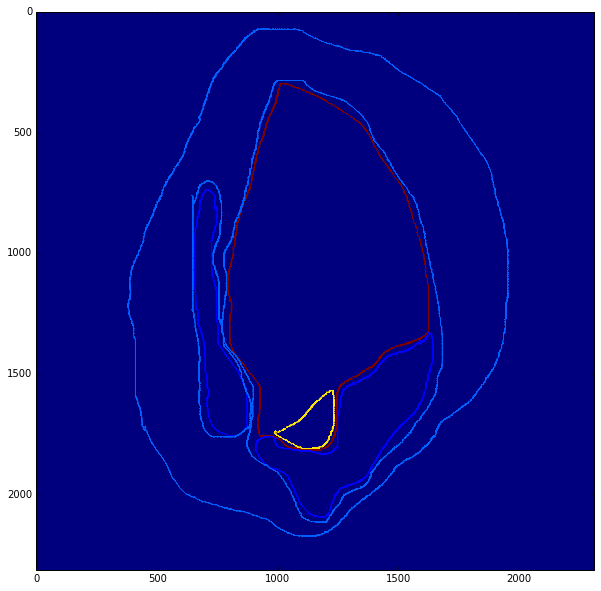

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,0])

In [ ]:
np.unique(img)

In [ ]:
plt.figure(figsize=(10,10))
a = np.copy(img)
i = 9
a[a!=i] = 0
a[a==i] = 255

# a = cv.dilate(a, kernel, 1)
a = cv.dilate(a, kernel)
plt.imshow(a, cmap='gnuplot')


In [ ]:
kernel = np.ones((5,5),np.uint8)

for i in np.unique(img):
    if i == 0:
        continue
    kik = np.copy(img)
    kik[kik!=i] = 0
    kik = cv.cvtColor(kik, cv.COLOR_BGR2GRAY)
    kik, contours, hierarchy = cv.findContours(kik, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
    cv.drawContours(kik, contours, 0, 255, -1)

    kik = cv.dilate(kik,kernel,iterations = 1)
    plt.figure(figsize=(10,10))
    plt.imshow(kik)

In [66]:
only_fibr = np.copy(img)
only_fibr[only_fibr!=2] = 0
only_fibr[only_fibr == 2] = 255

kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))

imgray = cv.cvtColor(only_fibr, cv.COLOR_BGR2GRAY)
imgray = cv.GaussianBlur(imgray,(5,5),0)
kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
imgray = cv.dilate(imgray,kernel)
(t, binary) = cv.threshold(imgray, 1, 255, cv.THRESH_BINARY)
(_, contours, hierarchy) = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)


# contours = [contours[i] for i in range(len(contours)) if hierarchy_all[0][i][2] == -1]
contours = [cnt for cnt in contours if cv.contourArea(cnt) > 100]
empty = np.zeros(imgray.shape, dtype=np.uint8)
cv.drawContours(empty, contours, -1, 255, 4)
(_, contours, hierarchy) = cv.findContours(empty, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)


# Distance by points

In [62]:
def find_difference_between_two_contours(extreme_points_cnt1, extreme_points_cnt2):
    distance =  dist.euclidean(extreme_points_cnt1[0], extreme_points_cnt2[0])+ \
                dist.euclidean(extreme_points_cnt1[1], extreme_points_cnt2[1])+ \
                dist.euclidean(extreme_points_cnt1[2], extreme_points_cnt2[2])+ \
                dist.euclidean(extreme_points_cnt1[3], extreme_points_cnt2[3])     
    return abs(distance)


contours_extreme_points = []
index_contours_extreme_points = 0
filtered_contours = []
cur_contour_presense = False
threshold = 1000

for i in range(len(contours)):
    if cv.contourArea(contours[i]) < 1500:
        continue
    leftmost = tuple(contours[i][contours[i][:,:,0].argmin()][0])
    rightmost = tuple(contours[i][contours[i][:,:,0].argmax()][0])
    topmost = tuple(contours[i][contours[i][:,:,1].argmin()][0])
    bottommost = tuple(contours[i][contours[i][:,:,1].argmax()][0])
    
    curr_extreme_point = (leftmost, rightmost, topmost, bottommost)
    
    if len(contours_extreme_points) > 0:
        for extreme_point in contours_extreme_points:
            difference = find_difference_between_two_contours(curr_extreme_point, 
                                                              extreme_point)
            if difference > threshold:
                cur_contour_presense = True
                break
        if cur_contour_presense:
            index_contours_extreme_points+=1
            contours_extreme_points.append(curr_extreme_point)
            filtered_contours.append(contours[i])
            cur_contour_presense = False
    else:
        filtered_contours.append(contours[i])
        contours_extreme_points.append(curr_extreme_point)


# Distance by aspect ratio

In [52]:
def find_difference_aspect_ratio(cnt1, cnt2):
    x,y,w,h = cv.boundingRect(cnt1)
    aspect_ratio1 = float(w)/h
    x,y,w,h = cv.boundingRect(cnt2)
    aspect_ratio2 = float(w)/h
    return abs(aspect_ratio1 - aspect_ratio2)

filtered_contours = []
index_filtered_contours = 0
wether_add_new_contour = True

for i in range(len(contours)):
    if cv.contourArea(contours[i])<1500:
        continue
    if len(filtered_contours) == 0:
        filtered_contours.append(contours[i])
        continue
    
    for filtered_contour in filtered_contours:
        if find_difference_aspect_ratio(contours[i], filtered_contour) < 0.15:
            wether_add_new_contour = False
            print(find_difference_aspect_ratio(contours[i], filtered_contour))
            break
    if wether_add_new_contour:
        filtered_contours.append(contours[i])
    wether_add_new_contour = True


0.025247007986793912
0.09823765956872599
0.13221459445715755
0.0009920538432360848
0.004681706966316979
0.005718808569990852


# Distance by area

In [81]:
def find_difference_area(cnt1, cnt2):
    return abs(cv.contourArea(cnt1) - cv.contourArea(cnt2))

filtered_contours = []
index_filtered_contours = 0
wether_add_new_contour = True


for i in range(len(contours)):
    if cv.contourArea(contours[i])<1500:
        continue
    if len(filtered_contours) == 0:
        filtered_contours.append(contours[i])
        continue
    
    for filtered_contour in filtered_contours:
        if find_difference_area(contours[i], filtered_contour) < 125098:
            wether_add_new_contour = False
            break
    if wether_add_new_contour:
        filtered_contours.append(contours[i])
    wether_add_new_contour = True

0.025247007986793912
0.09823765956872599
0.13221459445715755
0.0009920538432360848
0.004681706966316979
0.005718808569990852


In [19]:
for i in range(len(filtered_contours)):
    x,y,w,h = cv.boundingRect(filtered_contours[0])
    aspect_ratio1 = float(w)/h
    x,y,w,h = cv.boundingRect(filtered_contours[i])
    aspect_ratio2 = float(w)/h
    print(i, ' : ', abs(aspect_ratio1 - aspect_ratio2))

0  :  0.0
1  :  0.8053489481499397


In [11]:

for i in range(len(contours)):
    area = cv.contourArea(contours[0])
    equi_diameter1 = np.sqrt(4*area/np.pi)
    area = cv.contourArea(contours[i])
    equi_diameter2 = np.sqrt(4*area/np.pi)
    print(equi_diameter1 - equi_diameter2)   

0.0
9.053430697079193
37.50907461294415
47.11978892738151
-468.400086953174
-445.82724140712577
-372.97729292089997
-347.0780258112513


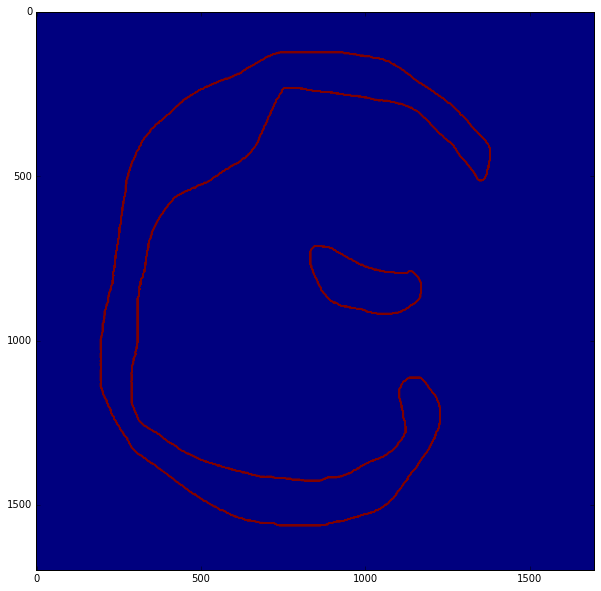

In [82]:
empty = np.zeros(imgray.shape, dtype=np.uint8)
cv.drawContours(empty, filtered_contours, -1, 255, 5)
plt.figure(figsize=(10,10))
plt.imshow(empty)

In [77]:
cv.contourArea(filtered_contours[-2]) - cv.contourArea(filtered_contours[-1])

122098.5

In [71]:
len(filtered_contours)

8

42622.0
386336.5


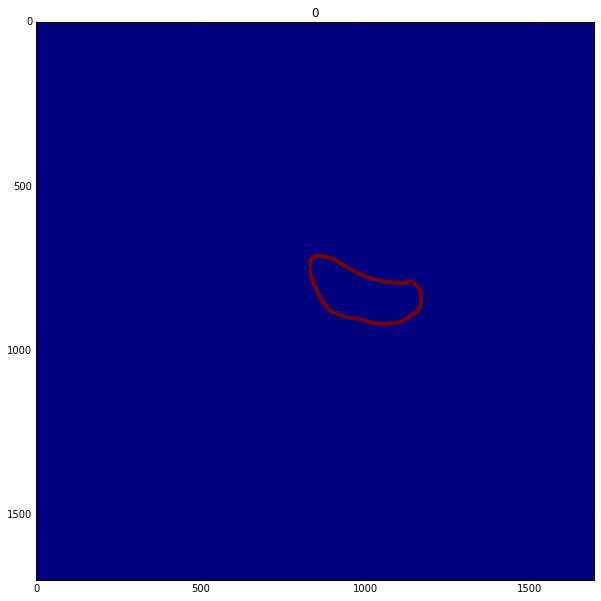

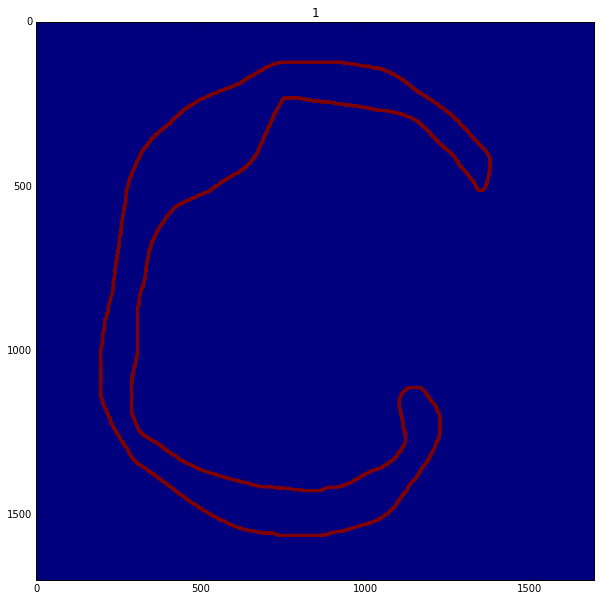

In [83]:
i=0
for cnt in filtered_contours:
    a = np.zeros(img.shape[:2])
    print(cv.contourArea(cnt))
    cv.drawContours(a, [cnt], 0, 255, 10)
    plt.figure(figsize=(10,10))
    plt.title(str(i))
    plt.imshow(a)
    i+=1


In [ ]:
index = 0
depth = 0
while True:
    if hierarchy_all[0][index][2] == -1:
        depth += 1
        break
    else:
        index = hierarchy_all[0][index][3]
        depth += 1

In [95]:
img = cv.imread('/home/bohdan/Desktop/KIK/10251_14_226.png')

In [96]:
np.unique(img.reshape(-1, img.shape[2]), axis=0)

array([[  0,   0,   0],
       [  0,   0, 255],
       [  0, 255,   0],
       [127,   0, 255],
       [128, 130, 128],
       [255,   0, 255]], dtype=uint8)